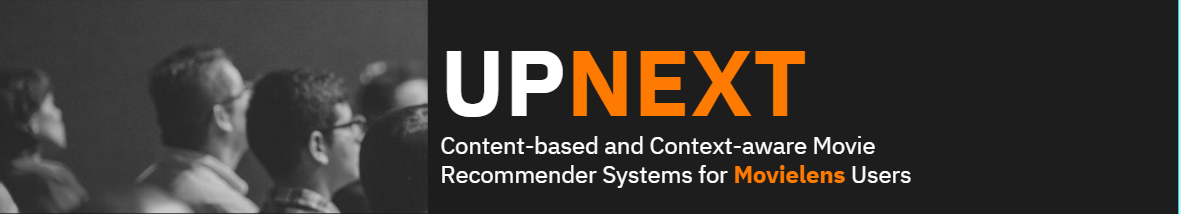

In [53]:
display(_image(filename="header.PNG"))

<h2><font color='darkorange'> Executive Summary </font></h2>

<p style="text-align:justify">The growth of digital movie streaming over the years paved way to the creation of a huge amount of data containing ratings of users to movies, content metadata such as genre and title of movies, context of the user like gender age, and occupations$^1$. Recommender systems are helpful in trying to predict the preference or the possible ratings of users for items that they haven't tried yet. In this technical report the team aims to answer How might we provide effective movie recommendations using several user specific features and movie features?</p>
<p style="text-align:justify">Using the MovieLens 1M dataset that contains movies from 1995 to 2015 and has million of anonymous ratings from six thousand users who rated at least twenty movies we explored the different characteristics of genre, age, occupation, and gender in terms of count and its average ratings. We found interesting insights such as older group tend to rate higher compared to the younger ones, demographics of the Movielens users, and drama as one of the most popular genre in the MovieLens. These content metadata and context of the users are used as features to our recommender system models.</p>
<p style="text-align:justify">The team developed content-based recommender system using genre and title as the features. We preprocessed the text using NLTK and converted it to machine readable representation using TF-idf. The TF-idf features are used to train our model based recommender system. The results that we got are similar to the user preference in terms of genre.</p>
<p style="text-align:justify">The team also developed several Context-Aware recommender system using genre, age group, and occupation. the recommendations made are more influenced by the filters set instead of the viewing or rating history. Using pre-filtering method, the model did poorly for some of the context used due to its effect on initial filtering of data. For both of the post filtering and contextual modeling, the results that we got performed well even on having multiple context at a time.  The team also developed a combination of content based and context aware models by getting its weighted sum in order to get a more specific recommendation based on the content and context of the user.</p>
<p style="text-align:justify">For future studies, we suggested to use a larger dataset, try other models, and perform evaluation metrics to further validate the results.</p>

In [52]:
import re
import os
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, Ridge
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import HTML
from IPython.display import Image as _image

tqdm.pandas()

import datetime

import pyspark
from pyspark.ml import Pipeline
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.regression import FMRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import (StringIndexer, VectorAssembler, VectorIndexer,
                                OneHotEncoder)

from surprise import Reader, Dataset, KNNWithMeans

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Download nltk requirements
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')


ML_COLORS = ['darkorange']

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<style>
.output_png {
    display: table-cell;
    text-align: center;
    horizontal-align: middle;
    vertical-align: middle;
    margin:auto;
}

tbody, thead {
    margin-left:100px;
}

</style>
<form action="javascript:code_toggle()"><input type="submit"
value="Click here to toggle on/off the raw code."></form>''')

In [54]:
# define the context aware recommender system
# code revised from prof leo's code. thank you!

class ContextAwareRS:
    """Base class for context-aware recommender systems"""

    def __init__(self, data, context_vars, rating_scale, sim_options=None):
        """Initialize the context aware recommender system given the
        ratings data and context variables
        """
        # Initialize static variables
        self.data = data
        self.context_vars = context_vars
        self.rating_scale = rating_scale
        if sim_options is None:
            self.sim_options = {'name': 'pearson', 'user_based': False,
                                'min_support': 0, 'shrinkage': 0}
        else:
            self.sim_options = sim_options

        # Initialize recsys model
        self.model = None
        
class ContextPreFiltering(ContextAwareRS):
    """Class for implementing context prefiltering algorithm with a
    neighborhood-based collaborative filtering algorithm
    """

    def __init__(
        self, data, context_vars, rating_scale, sim_options=None, k=None):
        """Initialize the context-prefiltering model"""
        super().__init__(data, context_vars, sim_options)
        if k is None:
            self.k = 5
        else:
            self.k = k

        # Initialize current data - this will be the 'filtered' data
        # based on context
        self.cur_data = None

    def fit(self, context_var_values):
        """Fit a context-aware recsys given context_vars_value"""
        # Get current data based on given context values
        cur_data = self.data.copy()
        for col, val in zip(self.context_vars, context_var_values):
            # If a None value is given, skip that column
            if val is not None:
                cur_data = cur_data.loc[cur_data.loc[:, col] == val]

        # Append to the CPF object for reference later
        self.cur_data = cur_data

        # Perform KNNWithMeans training
        reader = Reader(self.rating_scale)
        dataset = Dataset.load_from_df(self.cur_data.iloc[:, :3], reader)
        knn = KNNWithMeans(k=self.k, sim_options=self.sim_options)
        knn.fit(dataset.build_full_trainset())

        # Save model to object
        self.model = knn

    def show_top_k(self, user_id, top_k=20):
        """Return the context-aware top-k recommendations for user"""
        # Retrieve items not seen by the user
        seen_items = (self.cur_data[self.cur_data.iloc[:, 0] == user_id]
                      .iloc[:, 1].unique())
        #if seen_items == []:
        #    print('no seen movies, so recomms will have same rating')
        #else:
        #    pass
        unseen_items = (
            self.cur_data[~self.cur_data.iloc[:, 1].isin(seen_items)]
            .iloc[:, 1].unique()
        )

        #return seen_items
        
        # Generate predictions
        predictions = [self.model.predict(user_id, item)
                       for item in unseen_items]

        # Sort predictions based on estimated rating
        return [(prediction.iid, prediction.est) 
                for prediction in sorted(predictions, 
                                         key=lambda x: -x.est)][:top_k]

class ContextPostFiltering(ContextAwareRS):
    """Class for implementing context postfiltering algorithm with a
    neighborhood-based collaborative filtering algorithm
    """

    def __init__(
        self, data, context_vars, rating_scale, sim_options=None, k=None):
        """Initialize the context-prefiltering model"""
        super().__init__(data, context_vars, sim_options)
        if k is None:
            self.k = 5
        else:
            self.k = k

        # Initialize filter matrix. This will be used to filter the
        # resulting ratings at prediction time
        self.cur_data = None
        self.filter_matrix = None

    def fit(self, context_var_values, min_rating=3):
        """Fit a context-aware recsys given context_vars_value"""
        # Get current data based on given context values
        cur_data = self.data.copy()
        for col, val in zip(self.context_vars, context_var_values):
            # If a None value is given, skip that column
            if val is not None:
                cur_data = cur_data.loc[cur_data.loc[:, col] == val]
        self.cur_data =cur_data

        # Solve for the filter matrix. Here, we take P(*, i, c) as the
        # ratio between users who rate the movie with
        # stars > min_rating, over the total number of users.
        filter_matrix = cur_data.groupby('movieid').rating.apply(
            lambda x: (x >= min_rating).sum() / len(x)
        )
        self.filter_matrix = filter_matrix

        # Aggregate data into two-dimensional ratings matrix
        aggregate_data = (self.data.groupby(self.data.columns[:2].tolist())
                          .rating.mean().reset_index())
        
        # Perform KNNWithMeans training
        reader = Reader(self.rating_scale)
        dataset = Dataset.load_from_df(aggregate_data, reader)
        knn = KNNWithMeans(k=self.k, sim_options=self.sim_options)
        knn.fit(dataset.build_full_trainset())

        # Save model to object
        self.model = knn

    def show_top_k(self, user_id, top_k=20):
        """Return the context-aware top-k recommendations for user"""
        # Retrieve items not seen by the user
        seen_items = (self.cur_data[self.cur_data.iloc[:, 0] == user_id]
                      .iloc[:, 1].unique())
        if seen_items == []:
            print('no seen movies, so recomms will have same rating')
        else:
            pass
        unseen_items = (
            self.cur_data[~self.cur_data.iloc[:, 1].isin(seen_items)]
            .iloc[:, 1].unique()
        )

        # Generate predictions
        predictions = pd.DataFrame([self.model.predict(user_id, item)
                                    for item in unseen_items])
        predictions = predictions.set_index(predictions.columns[1]).est

        # Perform the post-filtering process
        predictions = ((predictions * self.filter_matrix)
                       .sort_values(ascending=False))

        # Sort predictions based on estimated rating
        return predictions[:top_k]
    
class ContextualModeling(ContextAwareRS):
    """Class for implmenting contextual modeling using factorization
    machines
    """

    def __init__(self, data, context_vars):
        """Initialize the contextual modeling recommender system"""
        super().__init__(data, context_vars, None)

    def fit(self):
        """Fit given the context variable values"""
        # Set the pipeline for the Factorization machines
        pipe = Pipeline(stages=[
            # Create string indices for each string variable
            StringIndexer(
                inputCols=['userid', 'movieid'],
                outputCols=['useridIndex', 'movieidIndex']),

            # One hot encode variables
            OneHotEncoder(
                inputCols=['useridIndex', 'movieidIndex', 'age', 
                           'occupations'],
                outputCols=['userID', 'movieID', 'ageID', 'occID']),

            # Assemble onto one vector
            VectorAssembler(
                inputCols=['userID', 'movieID', 'ageID', 'gender', 'occID'],
                outputCol='features', handleInvalid='skip'),

            # Train a FM model
            FMRegressor(
                featuresCol='features', labelCol='rating', stepSize=0.001)
        ])

        # Create spark data frame then fit the model to it
        sdf = spark.createDataFrame(self.data)
        model = pipe.fit(sdf)

        # Save the model to object
        self.model = model

    def show_top_k(self, user_id, context_var_values, top_k=20):
        """Return the context-aware top-k recommendations for user"""
        # Get current data based on given context values
        cur_data = self.data.copy()
        for col, val in zip(self.context_vars, context_var_values):
            # If a None value is given, skip that column
            if val is not None:
                cur_data = cur_data.loc[cur_data.loc[:, col] == val]

        # Retrieve items not seen by the user
        seen_items = (cur_data[cur_data.iloc[:, 0] == user_id].iloc[:, 1]
                      .unique())
        unseen_items = (cur_data[~cur_data.iloc[:, 1].isin(seen_items)]
                        .iloc[:, 1].unique())

        # Setup test data frame
        test_df = pd.DataFrame({'movieid': unseen_items})
        test_df.loc[:, self.data.columns[0]] = user_id
        test_df.loc[:, self.context_vars[0]] = context_var_values[0]
        test_df.loc[:, self.context_vars[1]] = context_var_values[1]
        test_df.loc[:, self.context_vars[2]] = context_var_values[2]
        test_sdf = spark.createDataFrame(test_df)

        # Get predictions
        predictions = (self.model.transform(test_sdf)
                       .select(['movieid', 'prediction'])
                       .toPandas().sort_values('prediction', ascending=False))

        # Sort predictions based on estimated rating
        return predictions[:top_k]

<h2><font color='darkorange'> I. Introduction </font></h2>

<p style="text-align:justify">Movies have now become more accessible due to the emergence of digital streaming. Because of this, it paved the way to the creation of a huge amount of digital data on the viewers' activity and the movies themselves. One of the most popular use cases of big data on streaming information are recommender systems.</p>
    
<p style="text-align:justify">Recommender systems are helpful in trying to predict the preference or the possible ratings of users for items that they haven't tried yet. They give suggestions based on their algorithm as to what the consumer might prefer to purchase or use next. There are several ways to approach the creation of the recommender system, it could be purely ratings based, popularity based, content based or filtered by user contexts. In this study we tried to implement the content-based and context aware recommendations systems separately and also tried to create a simple combination of the two methods on a long-standing movie rating database Movielens.</p>
    
<p style="text-align:justify">Movielens is a research site with a recommender system powered by online users. Movie recommendations are made using collaborative filtering technology and the ratings that the other members enter. iIt does not provide a streaming platform, but is mainly a recommendation platform for movies and shows. Movielens was created by the group GroupLens Research who specializes in recommender systems, online communities, digital libraries, and GIS. They have several datasets available online. Their datasets, most notably Movielens, have been big contributors in several research endeavors and are widely cited due to its open-source nature.</p>



<b> Problem Statement </b>

<p style="text-align:justify"> With the huge amount of data available on user activity in movie streaming platforms, the team would like to implement several advanced recommender system techniques in order to find out which one works. How might we provide effective movie recommendations using several user specific features (gender, age, occupation) and movie features (title and genre)? </p>

<b>Motivation</b>

<p style="text-align:justify"> This technical report focuses on the feasibility of using several content-based and context aware recommender systems in generating recommendations for this specific movie rating dataset. The insights gathered here can be utilized to effectively create a good combination or pipeline of recommender systems in order to produce the best recommendations. </p>

<h2><font color='darkorange'> II. Methodology </font></h2>

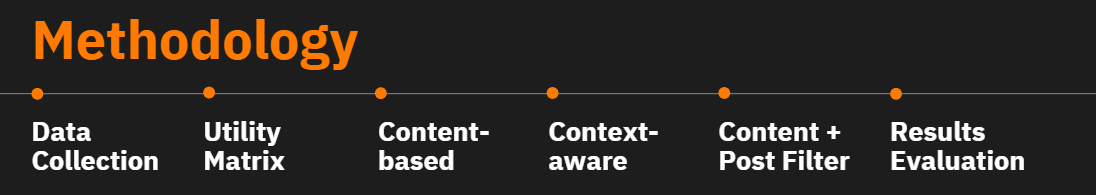

In [55]:
display(_image(filename="method.PNG"))

### Data Collection
The team collected the Movielens data and preprocessed it.

### Utility Matrix
The final dataframe was then set up by merging all the preprocessed dataframes into a final table which will be used. It includes the movie id, user id, rating, the genre for content and age, gender and occupation for context. 

### Content-based Recommender System
A content based recommender system was then built using the title and genre as the reference content. 

### Context-aware Recommender System
Three context aware recommender systems were then built which includes context pre-filtering, post-filtering and contextual modeling using different filters such as age gender and occupation. 

### Combined Recommender Systems
Lastly, we assigned weights and combined the results for contextual postfiltering and the content based systems. 

### Result Evaluation
The team then checked the recommendations for subjective evaluation and analysis against the profiles chosen.</p>

<h2><font color='darkorange'> III. Data Processing </font></h2>

### A. Extract and Preprocess Dataset

<p style="text-align:justify">In this technical report, we used Movielens 1M dataset extracted from <a href="https://www.kaggle.com/odedgolden/movielens-1m-dataset">Kaggle</a>. It contains more than a million anonymous ratings from six thousand users who rated at least twenty movies. The database contains four thousand movies from 1995 to 2015. The kaggle dataset is composed of three csv files namely:
    <ul>
        <li><i>movies.csv</i> - It contains the details about the movies like title and genre</li>
        <li><i>users.csv</i> - It contains the details of the users like gender, age, and occupation</li>
        <li><i>ratings.csv</i> - It contains the details about ratings given by the user to a movie</li>
    </ul>
</p>

In [56]:
display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 1. Snippet of movies.csv
</b></p>'''))
movies = pd.read_csv('movies.csv')
display(movies.head())

,movieid,title,genre
0,1,Toy Story,"['Animation', ""Children's"", 'Comedy']"
1,2,Jumanji,"['Adventure', ""Children's"", 'Fantasy']"
2,3,Grumpier Old Men,"['Comedy', 'Romance']"
3,4,Waiting to Exhale,"['Comedy', 'Drama']"
4,5,Father of the Bride Part II,['Comedy']


In [57]:
display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 2. Snippet of users.csv
</b></p>'''))
users = pd.read_csv('users.csv')
display(users.head())

,userid,gender,age,occupations,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [58]:
display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 3. Snippet of ratings.csv
</b></p>'''))
ratings = pd.read_csv('ratings.csv')
display(ratings.head())

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


<p style="text-align:justify">As an initial set of preprocessing the team merged the data into a single dataframe for easier manipulation.</p>

In [59]:
display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 4. Snippet of merged dataframes
</b></p>'''))

# merge the user ratings and the movie information
merged = pd.merge(ratings, movies, on='movieid')

# merge it into the user information
final = pd.merge(merged, users, on='userid')

display(final.head())

,userid,movieid,rating,timestamp,title,genre,gender,age,occupations,zip
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,['Drama'],F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach,"['Animation', ""Children's"", 'Musical']",F,1,10,48067
2,1,914,3,978301968,My Fair Lady,"['Musical', 'Romance']",F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich,['Drama'],F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A","['Animation', ""Children's"", 'Comedy']",F,1,10,48067


### B. Data Description

The final data features which were chosen in Movielens data sets can be found in the table below:

<center style="font-size:12px;font-style:default;"><b>Table 5  Table Feature Names, Types and Descriptions</b></center>

| Feature Name | Data Type | Description |
| :- | :- | :- |
| userid | int | Account user identifier |
| movieid | int | Movie identifier code |
| rating | int64 | Ratings given by the user for the particular movie |
| timestamp | datetime | Date the user made the rating |
| title | str | Title of the Movie |
| genre | str | Title of the Movie |
| gender | str | Title of the Movie |
| age | str | Title of the Movie |
| occupations | str | Title of the Movie |
| zip | str | Title of the Movie |

### C. User Profiles

<p style="text-align:justify">We selected two profile from the array of users in the database. First is Maria, a mom and an educator. She is 32 years old. Her movie preferences according to her rating history are more of the comedy and drama type of movies but a lot of the higher rated ones are particularly on children's movies probably due to her kids. Meanwhile another user, Jose, is a 28 years old male graduate student. His movie preferences are more of the classics, and most of them are on the drama genre. Throughout the report, we will reference the recommendations to these two profiles to see if the resulting recommendations are acceptable.</p>

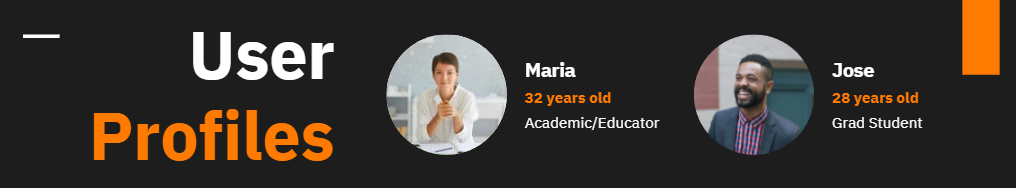

In [10]:
display(_image(filename="profiles.PNG"))

In [61]:
# first user's movie preferences

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 6. Maria's Seen & Rated Movies
</b></p>'''))

display(final[final.userid == 3388][['rating', 'title']])

,rating,title
743997,4,"Bug's Life, A"
743998,5,"Princess Bride, The"
743999,5,"Christmas Story, A"
744000,4,Ferris Bueller's Day Off
744001,3,Airplane!
744002,4,Rain Man
744003,4,Stand by Me
744004,3,Strictly Ballroom
744005,3,Raising Arizona
744006,3,Ghostbusters


In [62]:
# second user's movie preferences

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 7. Jose's Seen & Rated Movies
</b></p>'''))

display(final[final.userid == 1406][['rating', 'title']])

,rating,title
962332,5,Schindler's List
962333,3,Titanic
962334,4,GoodFellas
962335,4,American Beauty
962336,4,Raiders of the Lost Ark
962337,4,"Silence of the Lambs, The"
962338,5,"Shawshank Redemption, The"
962339,4,Pulp Fiction
962340,4,Good Will Hunting
962341,2,Fight Club


<h2><font color='darkorange'> IV. Exploratory Data Analysis </font></h2>

We performed exploratory data analysis particularly to the content and context of our datasets

In [13]:
# renaming list

rename = {"occupations": {0: "other", 1: "academic/educator", 2: "artist", 
                          3: "clerical/admin",  4: "college/grad student",
                          5: "customer service",  6: "doctor/health care",  
                          7: "executive/managerial", 8: "farmer",
                          9: "homemaker", 10: "K-12 student", 11: "lawyer", 
                          12: "programmer", 13: "retired", 
                          14: "sales/marketing", 15: "scientist", 
                          16: "self-employed", 17: "technician/engineer",
                          18: "tradesman/craftsman", 19: "unemployed", 
                          20: "writer"},
         "age": {1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 
                 45: "45-49", 50: "50-55", 56: "56+"}}

### A.  Top Genre

<p style="text-align:justify">In this section, we explore on the different characteristics of genre which is going to be used as a content for our content-based recommender system. </p>

<b>Count of movies in the Movielens per genre</b>

<p style="text-align:justify">Since most of the movies have multiple genres, we tranform the list of genres into a single column of genres. We then aggregated the genre to determine the count per genre.</p>

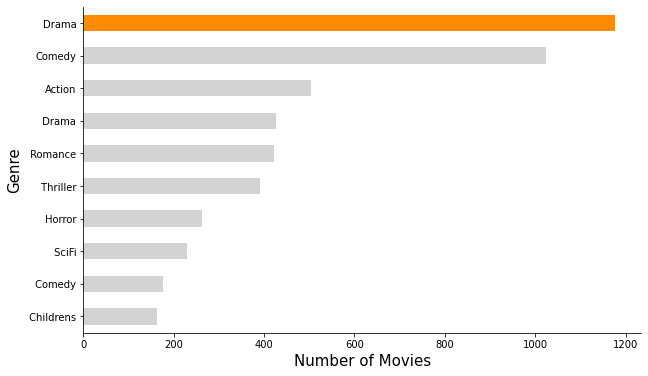

In [63]:
df_movies = movies.copy()
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 1. Top 10 genre with largest movie count.
</b></center>'''))
genre = (df_movies.genre.str.split(',')
                  .apply(lambda x: [re.sub(r'[^\w\s]', '', i) for i in x])
                  .explode()
                  .value_counts()[:10][::-1])

display(HTML(f'''<h3 style="text-align:center">
                Most of the movies in MovieLens have
                <b style="color:{"darkorange"}">
                drama</b> genre
                </h3>'''))

plt.figure(figsize=(10, 6))
genre.plot.barh(color= ['lightgray'] * (len(genre) - 1) + ['darkorange'])
plt.xlabel("Number of Movies", fontsize=15)
plt.ylabel("Genre", fontsize=15)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

<p style="text-align:justify">Drama is the genre that MovieLens invested alot followed by comedy and action.</p>

<b>Count of rated movies in the Movielens per genre</b>

<p style="text-align:justify">Similarly, to get the count of rated movies in the Movielens per genre, we tranform the list of genres into a single column of genres. If a particular movie has multiple genre then all genres under it will be counted for the ratings.</p>

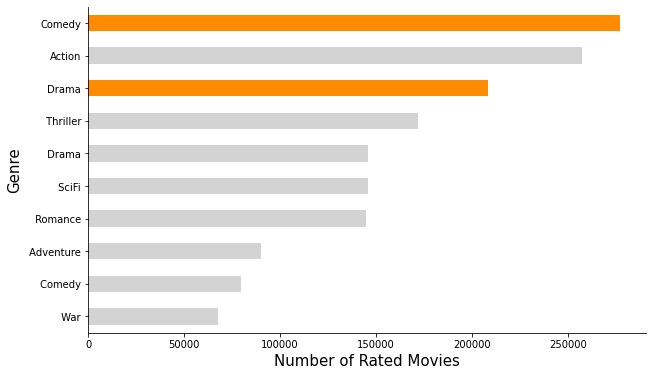

In [64]:
genre = (final.genre.str.split(',')
                  .apply(lambda x: [re.sub(r'[^\w\s]', '', i) for i in x])
                  .explode()
                  .value_counts()[:10][::-1])
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 2. Top 10 genre with most rated counts.
</b></center>'''))

display(HTML(f'''<h3 style="text-align:center">
                Most rated movies of MovieLens 
                have<b style="color:{"orange"}">
                comedy</b> genre
                </h3>'''))


plt.figure(figsize=(10, 6))
genre.plot.barh(color= ['lightgray'] * (len(genre) - 3) + ['darkorange']
                + ['lightgray'] + ['darkorange'])
plt.xlabel("Number of Rated Movies", fontsize=15)
plt.ylabel("Genre", fontsize=15)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

<p style="text-align:justify">Comedy is the most rated genre in MovieLens. We can also see that Drama is again one of the top rated movies. Having this information we can't tell if these ranking are high or low. We can go deeper by checking the average ratings per genre.</p>

<b>Average ratings per genre</b>

<p style="text-align:justify">The approach to get the average ratings per genre is similar to the previous section, but instead of counting the number of ratings, we get its average.</p>

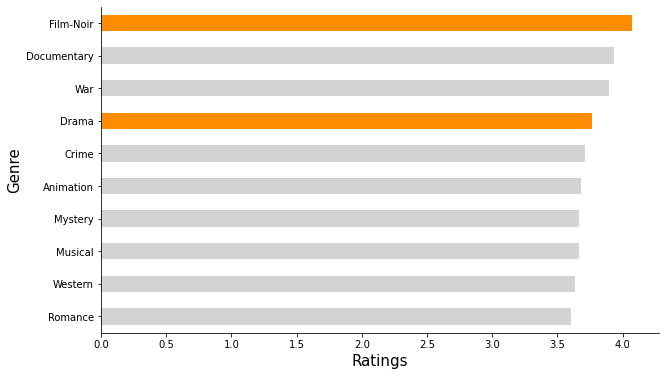

In [65]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 3. Top 10 genre with highest average ratings.
</b></center>'''))

display(HTML(f'''<h3 style="text-align:center">
                <b style="color:{"orange"}">
                Film Noir</b> has the highest average ratings
                </h3>'''))


plt.figure(figsize=(10, 6))

eda = final.copy()
eda['genre'] = eda.genre.apply(eval)
(eda.loc[:, ['genre', 'rating']].explode('genre')
   .groupby('genre')['rating'].mean()
   .sort_values(ascending=False)[:10][::-1]
   .plot.barh(color= ['lightgray'] * (len(genre) - 4) + ['darkorange']
                     + ['lightgray'] * 2 + ['darkorange']))
plt.xlabel("Ratings", fontsize=15)
plt.ylabel("Genre", fontsize=15)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()



<p style="text-align:justify">Film Noir or Hollywood Crime dramas has the highest average ratings among the genre of MovieLens. Overall, drama seems to be on top in terms of number of movies, number of rated movies, and average rating. </p>


### B. Number of Users per Category

<p style="text-align:justify"> We also tried to see which group per category has the most number of users. Gender-wise, we saw that there are more male users in the platform. Meawnhile, for the age brackets, 25-34 year olds have the most users followed by the 35-44 year old bracket. Last, for the occupation, most of them are also college/graduate students. followed by executive and academics.</p>

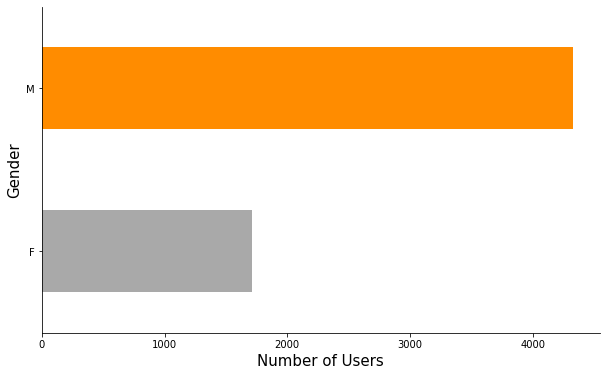

In [66]:
# plot user by gender

user_plot = users.replace(rename)

display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 4. User Distribution per Gender.
</b></center>'''))

gender_plot = (user_plot.gender.value_counts(ascending=True))

display(HTML(f'''<h3 style="text-align:center">
                Number of users based on<b style="color:{"orange"}">
                gender</b>
                </h3>'''))


plt.figure(figsize=(10, 6))
gender_plot.plot.barh(color= ['darkgray'] * (len(gender_plot) - 1) + ['darkorange'])
plt.xlabel("Number of Users", fontsize=15)
plt.ylabel("Gender", fontsize=15)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

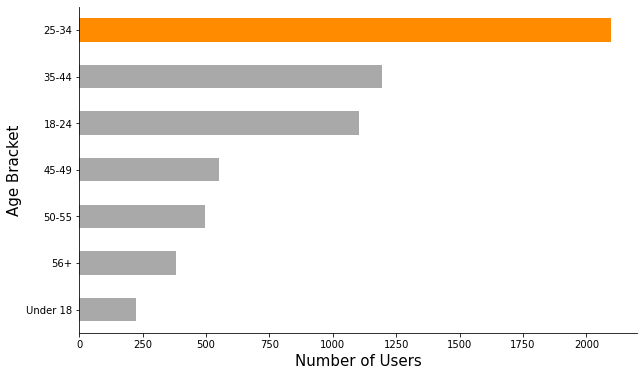

In [67]:
# plot user by age

age_plot = (user_plot.age.value_counts(ascending=True))

display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 5. User Distribution per Age Bracket.
</b></center>'''))

display(HTML(f'''<h3 style="text-align:center">
                Number of users based on<b style="color:{"orange"}">
                age bracket</b>
                </h3>'''))


plt.figure(figsize=(10, 6))
age_plot.plot.barh(color= ['darkgray'] * (len(age_plot) - 1) + ['darkorange'])
plt.xlabel("Number of Users", fontsize=15)
plt.ylabel("Age Bracket", fontsize=15)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

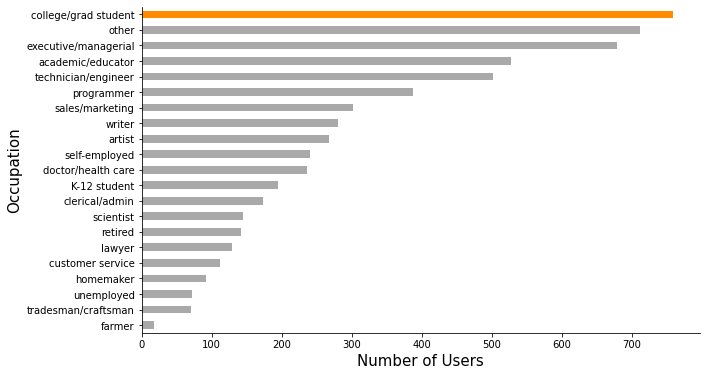

In [68]:
# plot user by occupation

occ_plot = (user_plot.occupations.value_counts(ascending=True))

display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 6. User Distribution per Occupation.
</b></center>'''))

display(HTML(f'''<h3 style="text-align:center">
                Number of users based on<b style="color:{"orange"}">
                occupation</b>
                </h3>'''))


plt.figure(figsize=(10, 6))
occ_plot.plot.barh(color= ['darkgray'] * (len(occ_plot) - 1) + ['darkorange'])
plt.xlabel("Number of Users", fontsize=15)
plt.ylabel("Occupation", fontsize=15)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### C. Average Ratings per Category

<p style="text-align:justify">Aside from getting the number of users per category we might want to get the average ratings per category as well. We might explore on the behavior of the different groups in our database.</p>

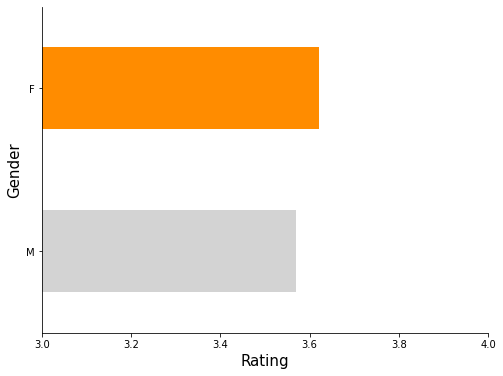

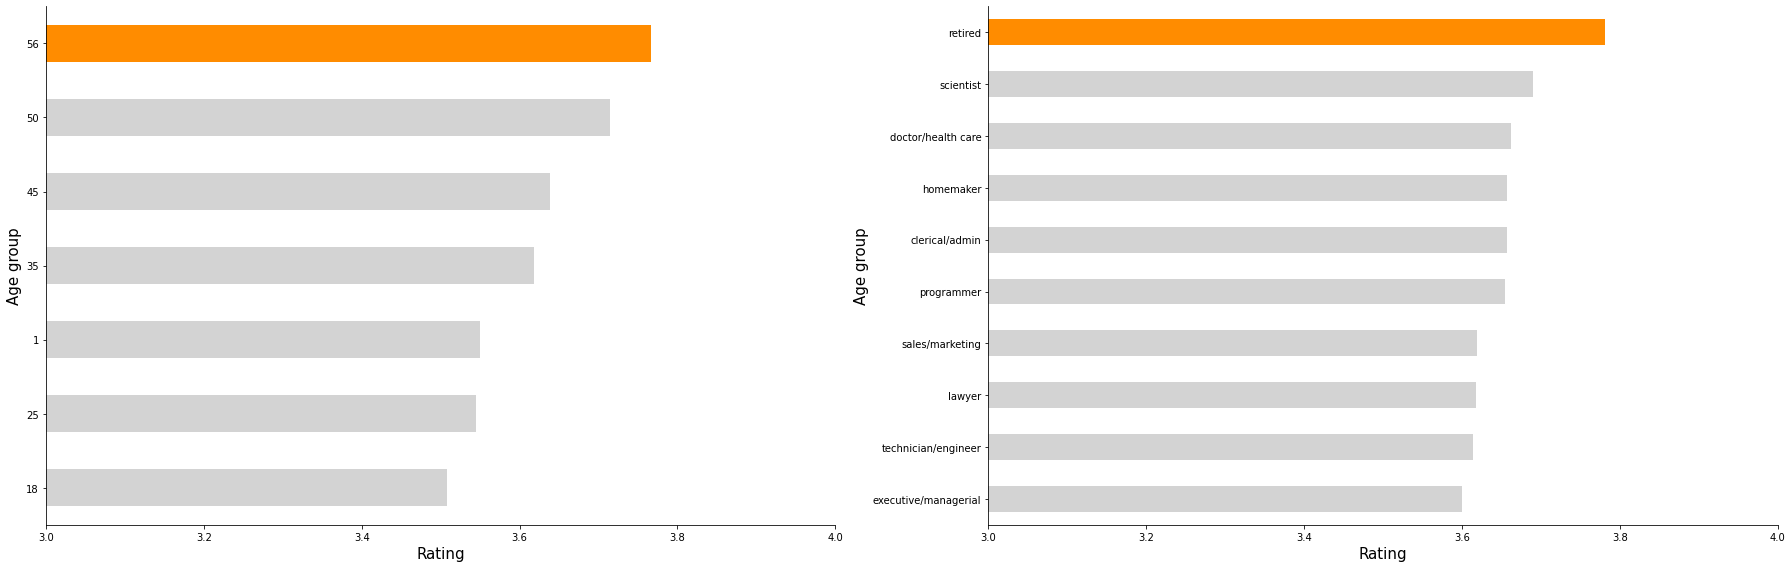

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 7. Average Ratings per Category.
</b></center>'''))

display(HTML(f'''<h3 style="text-align:center">
                <b style="color:{"darkorange"}">
                Female</b> and <b style="color:{"darkorange"}">Older</b>
                generation tend to rate higher
                </h3>'''))

(final.groupby('gender')['rating'].mean()
 .sort_values()
 .plot.barh(color=['lightgray','darkorange'], xlim=(3,4), ax=ax))

ax.set_xlabel("Rating", fontsize=15)
ax.set_ylabel("Gender", fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig, ax = plt.subplots(1, 2, figsize=(25,8))

(final.groupby('age')['rating'].mean()
 .sort_values().plot.barh(ax=ax[0], color= ['lightgray'] * 
                          (len(genre) - 4) + ['darkorange']
                          + ['lightgray'] * 2 + ['orange'], xlim=(3,4)))
ax[0].set_xlabel("Rating", fontsize=15)
ax[0].set_ylabel("Age group", fontsize=15)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

df = final.copy()
df['occupations'] = df.occupations.apply(lambda x: rename['occupations'][x])
(df.groupby('occupations')['rating'].mean()
 .sort_values(ascending=False)[:10][::-1]
 .plot.barh(ax=ax[1],color=['lightgray']  * 9 + ['darkorange'], xlim=(3,4)))
ax[1].set_xlabel("Rating", fontsize=15)
ax[1].set_ylabel("Age group", fontsize=15)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

fig.tight_layout()

<p style="text-align:justify">It seems that the rating increases as the age group gets older, it can also be seen by the occupation who rated it higher are retired users. It looks like the movies in movielens are more appreciated by older generation. Interestingly, female also tend to give a little higher ratings than male.</p>

<h2><font color='darkorange'> V. Results and Discussion </font></h2>

### A. Content-based Recommender System

<p style="text-align:justify">Content-based recommender system uses content metadata and user-profiles. By using content-based recommender system, we solve the problem of cold start that are present in collaborative filtering, it also recommend without regards to the popularity of the movie, and lastly it is also interpretable and intuitive. In this technical report, we used title and genre as our content metadata.$^2$</p>

<ol>
    <li> We used <code>nltk punkt</code> to properly tokenize the words in English that are going to be useful in the succeeding preprocessing of reviews.
    <li> We then performed casefolding to be able to have a case-insensitive reviews such that we want <code>GOOD</code> and <code>good</code> to be counted as single word. 
    <li> We also decided to perform lemmatization from <code>nltk WordNetLemmatizer</code> to the tokens such that we want <code>bed</code> and <code>beds</code> to be counted as single word.
    <li> We removed english stopwords from <code>nltk stopwords</code> to prevent low-level information such as <code>about</code>, <code>without</code>, etc from our movie titles in order to give more importance to the relevant information
<li> Lastly, we filtered words with less than 3 character length prevent words like <code>the</code>, <code>be</code> that wouldn't have importance for our analysis 
</ol></p>

In [70]:
df = pd.read_csv('final.csv')
df_movies = pd.read_csv('movies.csv')

def preprocess_movies(df_movies):
    """ Preprocess the content metadata of the movie
    
    Parameters
    ===========
    df_movies    :    pandas.DataFrame
                      database
    
    Returns
    ===========
    preprocess_movies   :  tuple
                           tuple of database and tfidf transformed data
    """
    df_movies['title_genre'] = df_movies.title +  ' '  + df_movies.genre
    df_movies['title_genre'] = df_movies.title_genre.str.replace(r'[^\w\s]', 
                                                            '', regex=True)

    # tokenize
    tokenize = df_movies.title_genre.apply(nltk.word_tokenize)

    # casefold
    lower_case = tokenize.apply(lambda x:list(map(lambda y: y.casefold(), x)))


    # lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatize = lower_case.apply(lambda x: list(map(lemmatizer.lemmatize,
                                                             x)))

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_stopwords = lemmatize.apply(lambda x:
                                        list(filter(lambda y: y
                                                not in stop_words,
                                                              x)))

    # filter words with less than 3 character length
    filtered_words = filtered_stopwords.apply(lambda x:
                                                       list(filter(lambda y:
                                                                   len(y) > 3,
                                                                   x)))

    df_movies['clean'] = (filtered_words.apply(' '.join))

    tfidf_vectorizer = TfidfVectorizer(token_pattern=r'\b[a-z]+\b', 
                                       ngram_range=(1, 2),
                                       max_df=0.8,
                                       min_df=0.01)


    tfidf = tfidf_vectorizer.fit_transform(df_movies.clean)

    svd = TruncatedSVD(n_components=20, random_state=0)
    X_new = svd.fit_transform(tfidf)
    
    return df_movies, X_new


<p style="text-align:justify">Now we have to convert are text data into a machine readable format which is a number. We can do this by training a Tf-idf vector using <code>sklearn.feature_extraction.text.TfidfVectorizer</code>. We have used the following parameters for the <code>TfidfVectorizer</code>:
<ul>
    <li>token_pattern : <code>r'\b[a-z]+\b'</code> - We have defined words as strictly composed of letters in the alphabet prefixed and suffixed by a word boundary</li>
    <li>ngram_range : <code>(1, 2)</code> - We used 1 to 2 ngrams to capture single and compound words such as <i>white house</i>, and <i>house</i></li>
    <li>max_df : <code>0.8</code> - We set the limit of the maximum document frequency to be 80% to remove words that appear too frequently</li>
    <li>min_df : <code>0.01</code> - We set the limit of the minimum document frequency to be 1% to ignore the words that appear too infrequently to our data that would improve also the performance of our model.</li></ul></p>

In [71]:
def content_recom(user, df, df_movies, X_new, top_k=10, **kwargs):
    """ Perform content model based recommender sytem for a single user
    
    Parameters
    ===========
    user        :    int 
                     user id
    df          :    pandas.DataFrame
                     full database
    df_movies   :    pandas.DataFrame
                     movies database
    X_new       :    numpy.ndarray
                     tfidf transformed features
    top_k       :    int
                     number of recommendations
    
    Returns
    ===========
    content_recom  : pandas.DataFrame
                     dataframe of recommended movies
    """
    if 'pre' in kwargs.keys():
        df = df[df[kwargs['context_var']] == kwargs['context_var_value']]
        df = df.reset_index()
    
    recom = {}
    df_user = df[df.userid==user].copy().sort_values(by='movieid') 
    profile = {
    'user': df_user.userid.unique()[0],
    'gender' : df_user.gender.unique()[0],
    'timestamp' : None,
    'age' : df_user.age.unique()[0],
    'occupations' : df_user.occupations.unique()[0],
    'zip' : df_user.zip.unique()[0],
    }
    
    df_out = pd.DataFrame()
    
    seen = set(df_user.movieid)
    unseen = set(df.movieid) - seen
    df_movies = df_movies.sort_values(by='movieid')
    movie_index_seen = df_movies[df_movies.movieid.isin(
            sorted(seen))].index

    X = X_new[movie_index_seen]
    y = df_user.rating.to_numpy()
    movie_index_unseen = df_movies[df_movies.movieid.isin(
        sorted(unseen))].index
    X_test = X_new[movie_index_unseen, :]
    model = Ridge(random_state=143)

    try:
        model.fit(X, y)
        new_rating = model.predict(X_test)
        limit = len(new_rating) if 'post' in kwargs.keys() else top_k
        top_recom = np.argsort(new_rating, kind='mergesort')[::-1][:limit]
        top_item = np.array(sorted(unseen))[top_recom]
        for i, item in enumerate(top_item):
            temp = profile.copy()
            temp['movieid'] = item
            temp['title'] = df_movies[df_movies.movieid == 
                                      item].title.to_list()[0]
            temp['genre'] = df_movies[df_movies.movieid == 
                                      item].genre.to_list()[0]
            temp['rating'] = new_rating[top_recom[i]]
            df_out = df_out.append(pd.DataFrame(temp, 
                                   index=[0])).reset_index(drop=True)
        
    except ValueError:
        pass
    
    if 'post' in kwargs.keys():
        df_out = df_out[df_out[kwargs['context_var']] == 
                        kwargs['context_var_value']]
    
    return df_out[:top_k]

<p style="text-align:justify">Let us look on how our model performed on our two customer persona:</p>

#### Maria's Recommendations

In [99]:
display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 8. Maria's Recommended movies based on content metadata
</b></p>'''))

df_movies, X_new = preprocess_movies(df_movies)
display(content_recom(3388, df, df_movies, X_new).iloc[:, [0, 6, 7, 8]])

,user,movieid,title,genre
0,3388,3945,Digimon: The Movie,"['Adventure', 'Animation', ""Children's""]"
1,3388,2899,Gulliver's Travels,"['Adventure', 'Animation', ""Children's""]"
2,3388,2800,Little Nemo: Adventures in Slumberland,"['Animation', ""Children's""]"
3,3388,2116,"Lord of the Rings, The","['Adventure', 'Animation', ""Children's"", 'Sci-..."
4,3388,2099,Song of the South,"['Adventure', 'Animation', ""Children's"", 'Musi..."
5,3388,1030,Pete's Dragon,"['Adventure', 'Animation', ""Children's"", 'Musi..."
6,3388,1881,Quest for Camelot,"['Adventure', 'Animation', ""Children's"", 'Fant..."
7,3388,3754,"Adventures of Rocky and Bullwinkle, The","['Animation', ""Children's"", 'Comedy']"
8,3388,3799,Pokémon the Movie 2000,"['Animation', ""Children's""]"
9,3388,3615,Dinosaur,"['Animation', ""Children's""]"


<p style="text-align:justify">The recommended movies for Maria revolves around the genre of adventure, animation, and children which is similar to her profile that we presented earlier which means we got a good result of recommendation based on the genre. These movies are digimon, little nemo, the lord of the rings, song of the south, and many more.</p>

#### Jose's Recommendations

In [100]:
display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 9. Jose's Recommended movies based on content metadata
</b></p>'''))

df_movies, X_new = preprocess_movies(df_movies)
display(content_recom(1406, df, df_movies, X_new).iloc[:, [0, 6, 7, 8]])

,user,movieid,title,genre
0,1406,2764,"Thomas Crown Affair, The","['Crime', 'Drama', 'Thriller']"
1,1406,1620,Kiss the Girls,"['Crime', 'Drama', 'Thriller']"
2,1406,1598,Desperate Measures,"['Crime', 'Drama', 'Thriller']"
3,1406,1227,Once Upon a Time in America,"['Crime', 'Drama', 'Thriller']"
4,1406,608,Fargo,"['Crime', 'Drama', 'Thriller']"
5,1406,463,Guilty as Sin,"['Crime', 'Drama', 'Thriller']"
6,1406,259,Kiss of Death,"['Crime', 'Drama', 'Thriller']"
7,1406,149,Amateur,"['Crime', 'Drama', 'Thriller']"
8,1406,22,Copycat,"['Crime', 'Drama', 'Thriller']"
9,1406,3900,Crime and Punishment in Suburbia,"['Comedy', 'Drama']"


<p style="text-align:justify">Meanwhile for Jose, the recommended movies for him with predicted rating of almost 4, are thomas crown affair, kiss the girls, desparate measures, once upon a time in america. Personally I am not familiar with these movies but they are all under crime, drama, and thriller which is again similar to the profile that we have presented earlier.</p>

### B. Context-aware Recommender System

In [75]:
# prepare matrix for context-aware RS

sample = final.copy()
sample = sample[['userid', 'movieid', 'rating', 
                 'gender', 'age', 'occupations']]
encode_nums = {"gender":     {"M": 0, "F": 1},
               "age": {1 : 0, 18 : 1, 25 : 2, 35 : 3, 
                       45 : 4, 50 : 5, 56 : 6 }}
sample = sample.replace(encode_nums)

<p style="text-align:justify">For context aware systems, we tried three models, context pre-filtering, post-filtering and contextual modeling. For the pre and post filtering methods we used knn with k value of 5. Meanwhile for contextual modeling we used a latent factor model and Factorization Machines Regressor learning algorithm.$^3$</p>

<p style="text-align:justify">In general one thing that we noticed with context-aware recommendations are that they are heavily influenced by the filters used more than the viewing history. Evidenced by the suggestions to Maria in the reulsts below which are not exactly child friendly and are more adult appropriate. There could be a problem if the user profile doesnt match the activity.</p>

#### Context Pre-filtering

<p style="text-align:justify">For Maria the mom, we can see that there are some common suggestions when filtered only by gender or by age. No results were generated when we used the occupation filter due to the effect of pre-filtering the initial utility matrix which made it harder to find similar items for the recommender system. That is one of the drawbacks of pre-filtering. The same reason caused the model to fail when we tried to implement 2 or 3 filters together.</p>

In [76]:
# recommendations with context filters

cpre = ContextPreFiltering(sample, ['gender'], (1, 5))
cpre.fit([1])
cpre_recommendations1 = cpre.show_top_k(3388)
recom_table = final.loc[[i[0] for i in cpre_recommendations1], ['title']]
recom_table['ratings'] = [i[1] for i in cpre_recommendations1]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 10. Maria's Recommendations - Gender Filter (Female)
</b></p>'''))
display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
1450,Total Recall,5
3292,"Rocky Horror Picture Show, The",5
2538,Meet the Parents,5
687,Dragonheart,5
1780,Spellbound,5
2304,"Shawshank Redemption, The",5
681,Lethal Weapon 3,5
787,Lethal Weapon,5
3817,Desperado,5
3245,Chasing Amy,5


In [77]:
# recommendations with context filters

cpre = ContextPreFiltering(sample, ['age'], (1, 5))
cpre.fit([2])
cpre_recommendations1 = cpre.show_top_k(3388)
recom_table = final.loc[[i[0] for i in cpre_recommendations1], ['title']]
recom_table['ratings'] = [i[1] for i in cpre_recommendations1]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 11. Maria's Recommendations - Age Filter (25-34 years old)
</b></p>'''))
display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
1300,Sixteen Candles,5
720,Babe: Pig in the City,5
1795,"Howling, The",5
167,Independence Day (ID4),5
3410,"Omega Man, The",5
853,Highlander,5
1780,Spellbound,5
787,Lethal Weapon,5
2358,"Few Good Men, A",5
2823,Milk Money,5


Luckily for Jose, all of the single filters worked but when we tried to use double and triple filters it did not work just like for user Maria.

In [78]:
# recommendations with context filters

cpre = ContextPreFiltering(sample, ['gender'], (1, 5))
cpre.fit([0])
cpre_recommendations1 = cpre.show_top_k(1406)
recom_table = final.loc[[i[0] for i in cpre_recommendations1], ['title']]
recom_table['ratings'] = [i[1] for i in cpre_recommendations1]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 12. Jose's Recommendations - Gender Filter (Male)
</b></p>'''))
display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
3470,Poltergeist,5.000000
3233,Private Parts,5.000000
3517,Kids,5.000000
3172,Pi,5.000000
787,Lethal Weapon,5.000000
3656,Junk Mail,5.000000
439,Star Wars: Episode V - The Empire Strikes Back,5.000000
985,Indiana Jones and the Temple of Doom,5.000000
130,Dances with Wolves,5.000000
989,King Kong,5.000000


In [79]:
# recommendations with context filters

cpre = ContextPreFiltering(sample, ['age'], (1, 5))
cpre.fit([2])
cpre_recommendations1 = cpre.show_top_k(1406)
recom_table = final.loc[[i[0] for i in cpre_recommendations1], ['title']]
recom_table['ratings'] = [i[1] for i in cpre_recommendations1]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 13. Jose's Recommendations - Age Filter (25-34 years old)
</b></p>'''))
display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
3022,Clockers,5
3134,Alien,5
1795,"Howling, The",5
3140,"Good, The Bad and The Ugly, The",5
167,Independence Day (ID4),5
3410,"Omega Man, The",5
853,Highlander,5
1780,Spellbound,5
787,Lethal Weapon,5
2358,"Few Good Men, A",5


In [80]:
# recommendations with context filters

cpre = ContextPreFiltering(sample, ['occupations'], (1, 5))
cpre.fit([4])
cpre_recommendations1 = cpre.show_top_k(1406)
recom_table = final.loc[[i[0] for i in cpre_recommendations1], ['title']]
recom_table['ratings'] = [i[1] for i in cpre_recommendations1]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 14. Jose's Recommendations - Occupation Filter (Grad Student)
</b></p>'''))
display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
326,Blast from the Past,5
3637,What Planet Are You From?,5
3073,"League of Their Own, A",5
583,Laura,5
3245,Chasing Amy,5
3711,Star Wars: Episode IV - A New Hope,5
2131,Dances with Wolves,5
2342,Mulan,5
602,"Fly, The",5
669,Star Wars: Episode V - The Empire Strikes Back,5


#### Context Post-filtering

<p style="text-align:justify">Next for context post-filtering, we do the recommendation system first before we actually filter them using our context filters. There was no problem creating the recommender system first because the uitility matrix used was still complete. This worked better for both users since we used the complete original matrix to create the recommendations.</p>

<p style="text-align:justify">Compared to pre-filtering we have more overlaps across the models. It also worked for two and three filters at the same time, both for Maria and Jose.</p>

In [81]:
# recommendations with context filters

cpost = ContextPostFiltering(sample, ['gender'], (1, 5))
cpost.fit([1])
cpost_recommendations1 = cpost.show_top_k(3388)
recom_table = final.loc[[i for i in cpost_recommendations1.index], ['title']]
recom_table['ratings'] = [cpost_recommendations1[i] for 
                          i in cpost_recommendations1.index]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 15. Maria's Recommendations - Gender Filter (Female)
</b></p>'''))
display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
3881,"Mosquito Coast, The",5.000000
3607,Candyman,5.000000
787,Lethal Weapon,5.000000
3382,Sneakers,5.000000
3134,Alien,4.965224
1148,Tales from the Crypt Presents: Bordello of Blood,4.911797
3410,"Omega Man, The",4.823853
363,Lord of the Flies,4.797265
1250,When Harry Met Sally...,4.776346
2324,"Christmas Story, A",4.774076


In [82]:
# recommendations with context filters

cpost = ContextPostFiltering(sample, ['age'], (1, 5))
cpost.fit([2])
cpost_recommendations1 = cpost.show_top_k(3388)
recom_table = final.loc[[i for i in cpost_recommendations1.index], ['title']]
recom_table['ratings'] = [cpost_recommendations1[i] for 
                          i in cpost_recommendations1.index]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 16. Maria's Recommendations - Age Filter (25-34 years old)
</b></p>'''))
display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
787,Lethal Weapon,5.000000
3172,Pi,5.000000
578,"Hidden, The",5.000000
2905,"Ref, The",5.000000
1148,Tales from the Crypt Presents: Bordello of Blood,4.883656
3410,"Omega Man, The",4.823853
1260,Batman Returns,4.814538
1250,When Harry Met Sally...,4.800956
2324,"Christmas Story, A",4.765292
3470,Poltergeist,4.757569


In [83]:
# recommendations with context filters

cpost = ContextPostFiltering(sample, ['occupations'], (1, 5))
cpost.fit([1])
cpost_recommendations1 = cpost.show_top_k(3388)
recom_table = final.loc[[i for i in cpost_recommendations1.index], ['title']]
recom_table['ratings'] = [cpost_recommendations1[i] for 
                          i in cpost_recommendations1.index]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 17. Maria's Recommendations - Occupation Filter (Academic)
</b></p>'''))
display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
3233,Private Parts,5.000000
787,Lethal Weapon,5.000000
3881,"Mosquito Coast, The",5.000000
2905,"Ref, The",5.000000
3134,Alien,4.965224
1148,Tales from the Crypt Presents: Bordello of Blood,4.883656
363,Lord of the Flies,4.797265
2324,"Christmas Story, A",4.774667
3470,Poltergeist,4.757569
1250,When Harry Met Sally...,4.729246


In [84]:
# recommendations with context filters

cpost = ContextPostFiltering(sample, ['occupations'], (1, 5))
cpost.fit([1])
cpost_recommendations1 = cpost.show_top_k(3388)
recom_table = final.loc[[i for i in cpost_recommendations1.index], ['title']]
recom_table['ratings'] = [cpost_recommendations1[i] for 
                          i in cpost_recommendations1.index]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 18. Maria's Recommendations - Gender & Age Filter 
(Female & 25-34 years old)
</b></p>'''))
display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
3233,Private Parts,5.000000
787,Lethal Weapon,5.000000
3881,"Mosquito Coast, The",5.000000
2905,"Ref, The",5.000000
3134,Alien,4.965224
1148,Tales from the Crypt Presents: Bordello of Blood,4.883656
363,Lord of the Flies,4.797265
2324,"Christmas Story, A",4.774667
3470,Poltergeist,4.757569
1250,When Harry Met Sally...,4.729246


In [85]:
# recommendations with context filters

cpost = ContextPostFiltering(sample, ['gender', 'age', 'occupations'], (1, 5))
cpost.fit([1, 2, 1])
cpost_recommendations1 = cpost.show_top_k(3388)
recom_table = final.loc[[i for i in cpost_recommendations1.index], ['title']]
recom_table['ratings'] = [cpost_recommendations1[i] for 
                          i in cpost_recommendations1.index]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 19. Maria's Recommendations - Gender, Age & Occupation Filter 
(Female, 25-34 years old, Academe)
</b></p>'''))
display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
2324,"Christmas Story, A",4.991697
3134,Alien,4.965224
1148,Tales from the Crypt Presents: Bordello of Blood,4.953422
1250,When Harry Met Sally...,4.880179
1260,Batman Returns,4.859958
363,Lord of the Flies,4.797265
1223,Ghostbusters,4.735763
720,Babe: Pig in the City,4.712796
1132,Scream,4.680457
1300,Sixteen Candles,4.671334


In [86]:
# recommendations with context filters

cpost = ContextPostFiltering(sample, ['gender'], (1, 5))
cpost.fit([0])
cpost_recommendations1 = cpost.show_top_k(1406)
recom_table = final.loc[[i for i in cpost_recommendations1.index], ['title']]
recom_table['ratings'] = [cpost_recommendations1[i] for 
                          i in cpost_recommendations1.index]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 20. Jose's Recommendations - Gender Filter (Male)
</b></p>'''))
display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
787,Lethal Weapon,5.000000
1830,Go,5.000000
3172,Pi,5.000000
989,King Kong,5.000000
3656,Junk Mail,5.000000
3233,Private Parts,5.000000
3280,Teenage Mutant Ninja Turtles,5.000000
3888,Three Kings,4.989583
3470,Poltergeist,4.881376
2444,Blazing Saddles,4.815147


In [87]:
# recommendations with context filters

cpost = ContextPostFiltering(sample, ['age'], (1, 5))
cpost.fit([2])
cpost_recommendations1 = cpost.show_top_k(1406)
recom_table = final.loc[[i for i in cpost_recommendations1.index], ['title']]
recom_table['ratings'] = [cpost_recommendations1[i] for 
                          i in cpost_recommendations1.index]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 21. Jose's Recommendations - Age Filter (25-34 years old)
</b></p>'''))

display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
3172,Pi,5.000000
787,Lethal Weapon,5.000000
3470,Poltergeist,4.881376
2444,Blazing Saddles,4.815147
954,Payback,4.799873
906,Super Mario Bros.,4.700580
2708,Flubber,4.682580
2931,Toy Story 2,4.665717
3517,Kids,4.635872
3410,"Omega Man, The",4.628656


In [88]:
# recommendations with context filters

cpost = ContextPostFiltering(sample, ['occupations'], (1, 5))
cpost.fit([4])
cpost_recommendations1 = cpost.show_top_k(1406)
recom_table = final.loc[[i for i in cpost_recommendations1.index], ['title']]
recom_table['ratings'] = [cpost_recommendations1[i] for 
                          i in cpost_recommendations1.index]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 22. Jose's Recommendations - Occupation Filter (Grad Student)
</b></p>'''))
display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
3470,Poltergeist,4.881376
906,Super Mario Bros.,4.794592
954,Payback,4.747700
326,Blast from the Past,4.671838
2925,Hercules,4.634679
3435,Queen Margot (La Reine Margot),4.629279
922,One Flew Over the Cuckoo's Nest,4.623585
1759,"Nosferatu (Nosferatu, eine Symphonie des Grauens)",4.614540
3224,Witness,4.601180
1111,Forbidden Planet,4.600113


In [89]:
# recommendations with context filters

cpost = ContextPostFiltering(sample, ['gender', 'age'], (1, 5))
cpost.fit([0, 2])
cpost_recommendations1 = cpost.show_top_k(1406)
recom_table = final.loc[[i for i in cpost_recommendations1.index], ['title']]
recom_table['ratings'] = [cpost_recommendations1[i] for 
                          i in cpost_recommendations1.index]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 23. Jose's Recommendations - Gender & Age Filter (Male, 25-34 years old)
</b></p>'''))

display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
787,Lethal Weapon,5.000000
3172,Pi,5.000000
3470,Poltergeist,4.881376
2444,Blazing Saddles,4.815147
954,Payback,4.772364
2708,Flubber,4.682580
2931,Toy Story 2,4.665717
3410,"Omega Man, The",4.628656
922,One Flew Over the Cuckoo's Nest,4.623585
858,101 Dalmatians,4.619160


In [90]:
# recommendations with context filters

cpost = ContextPostFiltering(sample, ['gender', 'age', 'occupations'], (1, 5))
cpost.fit([0, 2, 4])
cpost_recommendations1 = cpost.show_top_k(1406)
recom_table = final.loc[[i for i in cpost_recommendations1.index], ['title']]
recom_table['ratings'] = [cpost_recommendations1[i] for 
                          i in cpost_recommendations1.index]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 24. Jose's Recommendations - Gender, Age & Occupation Filter 
(Male, 25-34 years old, Grad Student)
</b></p>'''))

display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
954,Payback,4.883349
3470,Poltergeist,4.881376
906,Super Mario Bros.,4.794592
2186,Star Trek: First Contact,4.715575
1046,Carrie,4.709644
930,Pleasantville,4.708762
2708,Flubber,4.682580
326,Blast from the Past,4.671838
3730,Being There,4.632394
3435,Queen Margot (La Reine Margot),4.629279


In [98]:
# setup spark
config = pyspark.SparkConf().setAll([('spark.driver.memory', '12g')])
sc = SparkContext(conf=config)
spark = SparkSession.builder.config(conf=config).getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

#### Contextual Filtering

<p style="text-align:justify">In using contextual modeling, context is integrated into the model. Due to it being computationally expensive it was performed in Spark. The results below were also from a three filter model (age, gender & occupation). Interestingly, the recommendations here actually have no overlaps with the results from any post-filtering model used.</p>

In [92]:
# recommendations with context filters

cm = ContextualModeling(sample, ['gender', 'age', 'occupations'])
cm.fit()
cm_recommendations1 = cm.show_top_k(3388, [1, 2, 1])
recom_table = final.loc[[i for i in cm_recommendations1.index], ['title']]
recom_table['ratings'] = [cm_recommendations1['prediction'][i] for 
                          i in cm_recommendations1.index]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 25. Maria's Recommendations - Gender, Age & Occupation Filter 
(Female, 25-34 years old, Academe)
</b></p>'''))
display(recom_table)

,title,ratings
197,Larger Than Life,1.792370
87,Simon Birch,1.790603
1422,Ben-Hur,1.786599
920,D2: The Mighty Ducks,1.786394
1069,Man on the Moon,1.781901
1210,"Breakfast Club, The",1.781469
1061,Alien Nation,1.780635
1704,Some Like It Hot,1.780341
1571,In the Line of Fire,1.779848
331,Hook,1.779605


In [93]:
# recommendations with context filters

cm = ContextualModeling(sample, ['gender', 'age', 'occupations'])
cm.fit()
cm_recommendations1 = cm.show_top_k(1406, [0, 2, 4])
recom_table = final.loc[[i for i in cm_recommendations1.index], ['title']]
recom_table['ratings'] = [cm_recommendations1['prediction'][i] for 
                          i in cm_recommendations1.index]
display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 26. Jose's Recommendations - Gender, Age & Occupation Filter 
(Male, 25-34 years old, Grad Student)
</b></p>'''))
display(recom_table)

,title,ratings
882,"Last Emperor, The",1.364233
1064,Christmas Vacation,1.362749
2487,Austin Powers: The Spy Who Shagged Me,1.360718
2520,Amistad,1.360351
938,Toy Story,1.360330
2,My Fair Lady,1.360021
1935,"Good, The Bad and The Ugly, The",1.359694
622,Beauty and the Beast,1.358498
1436,"Girl, Interrupted",1.357950
5,"Princess Bride, The",1.357944


### C. Content based + Context aware recommendation

<p style="text-align:justify">Now we explore on mixing the results of content and context that we got. Perhaps, Maria wanted to explore movies that are on her genre while also having a female context of the movie. We did this by first normalizing the rating that we got for content based and post filtering context aware then perform a weighted sum, sort the order in terms of the added ratings in descending manner for the recommendations.</p>

#### Maria's Recommendations

In [101]:
display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 27. Maria's Recommended movies based on content metadata 
and gender context
</b></p>'''))

# recommendations with context filters
cpost = ContextPostFiltering(sample, ['gender'], (1, 5))
cpost.fit([1])
cpost_recommendations1 = cpost.show_top_k(3388, top_k=1000)
post = pd.DataFrame(cpost_recommendations1)
post.columns = ['post_ratings']

# content
df_movies, X_new = preprocess_movies(df_movies)
cont = content_recom(3388, df, df_movies, X_new, top_k=100)
cont = cont.set_index('movieid')

mix = pd.merge(cont, post, left_index=True, right_index=True)

mix['rating'] = (mix.rating-mix.rating.min()
                  /(mix.rating.max()-mix.rating.min()))
mix['post_ratings'] = ((mix.post_ratings-mix.post_ratings.min())
                       /(mix.post_ratings.max()-mix.post_ratings.min()))
mix['mix_ratings'] = mix.rating * 0.5 + mix.post_ratings * 0.5

display(mix.sort_values(by='mix_ratings', 
                        ascending=False)[:20].iloc[:, [0, 6]])

Computing the pearson similarity matrix...
Done computing similarity matrix.


,user,title
3470,3388,Dersu Uzala
1023,3388,Winnie the Pooh and the Blustery Day
1,3388,Toy Story
3114,3388,Toy Story 2
2139,3388,"Secret of NIMH, The"
1022,3388,Cinderella
3034,3388,Robin Hood
13,3388,Balto
2096,3388,Sleeping Beauty
1033,3388,"Fox and the Hound, The"


<p style="text-align:justify">The recommended movies for maria does not match with the movies that we got for content and context but we got a similar genre for the profile of Maria which is adventure, children, and animation. Some of the recommended movies are wiinie the pooh, Dersu Uzala, and toy story</p>


#### Jose's Recommendations

In [102]:
display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 28. Jose's Recommended movies based on content metadata 
and gender context
</b></p>'''))

# recommendations with context filters
cpost = ContextPostFiltering(sample, ['gender'], (1, 5))
cpost.fit([1])
cpost_recommendations1 = cpost.show_top_k(3388, top_k=1000)
post = pd.DataFrame(cpost_recommendations1)
post.columns = ['post_ratings']

# content
df_movies, X_new = preprocess_movies(df_movies)
cont = content_recom(1406, df, df_movies, X_new, top_k=100)
cont = cont.set_index('movieid')

mix = pd.merge(cont, post, left_index=True, right_index=True)

mix['rating'] = (mix.rating-mix.rating.min()
                  /(mix.rating.max()-mix.rating.min()))
mix['post_ratings'] = ((mix.post_ratings-mix.post_ratings.min())
                       /(mix.post_ratings.max()-mix.post_ratings.min()))
mix['mix_ratings'] = mix.rating * 0.5 + mix.post_ratings * 0.5

display(mix.sort_values(by='mix_ratings', 
                        ascending=False)[:20].iloc[:, [0, 6]])

Computing the pearson similarity matrix...
Done computing similarity matrix.


,user,title
1084,1406,Bonnie and Clyde
908,1406,North by Northwest
3147,1406,"Green Mile, The"
3362,1406,Dog Day Afternoon
3517,1406,"Bells, The"
1842,1406,Illtown
2438,1406,Outside Ozona
3019,1406,Drugstore Cowboy
3936,1406,"Phantom of the Opera, The"
1358,1406,Sling Blade


<p style="text-align:justify">Similarly for Jose, We got a match with genre of drama and crime. And some of the recommended movies are song of freedom, twenty four seven, and mr smith goes to washington</p>

<h2><font color='darkorange'> VI. Conclusion </font></h2>

<p style="text-align:justify">Several insights from the initial analysis of the data such as the most common user categories helped the team pick profiles to test in this study.</p>
    
<p style="text-align:justify">Using content based recommender systems highlight the similarity of the recommended movies to the viewing and rating history of the user. As evident in Maria's case, her profile as a middle aged female academician doesn't necessarily match or reflect in her viewing history which is dominated by children's shows. In this case the content based recommender system still gave suggestions that will appeal to her children. Meanwhile for Jose, the results also reflected his viewing history which is mostly drama. The content based system's recommendations were more of the same, which is good for the user if they do not want to explore other genre.</p>

<p style="text-align:justify">Meawnhile for context aware systems, the recommendations made are more influenced by the filters set instead of the viewing or rating history which was the opposite of the pre-filtering method. For Maria's case, the recommendations were no where near children appropriate content, and were more influenced by the age and gender context. </p>
    
<p style="text-align:justify">As for the disadvantages, contextual pre-filtering limits the movie choices even before trying to create a rating matrix so sometimes the wrong set of filters could make the system fail. That is not the case for contextual post filtering where we saw work for all types and combinations of filters. The same could be said for contextual modeling.</p>

<p style="text-align:justify">Combining the two systems by assigning equal weights to the results of the content based and context post-filtering generated the best results as it takes into account the theme and the filters to give a more varied roster of recommendations for the users.</p>

<h2><font color='darkorange'> VII. Recommendations </font></h2>

<p style="text-align:justify">Our recommendations to further improve our study in terms of data source is to try a larger dataset. In kaggle they also have Movielens 25M dataset on which the future researchers can explore. If available, they can use the images of the movies as a content metadata as well. In terms of models used,  We also recommend to try other models like Random Forest or Gradientboost for the Contextual modeling. Future researcher can also use deep learning models for recommender system for a very large datasets. And lastly, in terms of evaluation, we recommend to evaluate the models trained by performing a train and validation split. Tune the hyperparameters until you got the lowest error metric like Mean Absolute Error (MAE) or Mean Squared Error (MSE). Lastly, in order to fully validate the results of our model, we recommend to monitor the behavior of the user on which we gave our recommendation. If they liked our recommendation then it means our recommender system performed well otherwise there are some improvements that can be made in order to satisfy our user.</p>

<h2><font color='darkorange'> References </font></h2>

[1] White, S. (2021) "Streaming: How Digital Media is Transforming the Film Industry". https://medium.com/digital-society/streaming-how-digital-media-is-transforming-the-film-industry-1643aadb36ef<br><br>
[2] Abhijit, R. (2020). "Introduction To Recommender Systems- 1: Content-Based Filtering And Collaborative Filtering". https://towardsdatascience.com/introduction-to-recommender-systems-1-971bd274f421 <br><br>
[3] Espinosa, A. (2017). "The basics of Context-Aware Recommendations". https://medium.com/@andresespinosapc/the-basics-of-context-aware-recommendations-5dd7a939049b